__tasks:__
- [x] Check TFs in CRISPRi screens
- [ ] Plot

In [1]:
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
library(tidyverse)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### functions

In [2]:
read_genetable_collapsed <- function(file_path){
    #import collapsed genetable
    genetable_collapsed <- na.omit(read.table(
        file_path, header = FALSE, #skip = 4, 
        sep = '\t', na.strings = ' '))

    genetable_collapsed[4,3:length(genetable_collapsed)] = apply(
        genetable_collapsed[1:4,3:length(genetable_collapsed)], 2, paste, collapse="_")

    colnames(genetable_collapsed) <- genetable_collapsed[4,]
    genetable_collapsed = genetable_collapsed[5:dim(genetable_collapsed)[1],] %>% data.frame
}

In [3]:
get_score_df <- function(genetable_collapsed,score,up_hit='resistance_hit',down_hit='sensitivity_hit',threshold = 4){
    df = genetable_collapsed[,c('gene', 
                                paste0(score,'_ave_Rep1_Rep2_Mann.Whitney.p.value_'),
                                paste0(score,'_ave_Rep1_Rep2_average.phenotype.of.strongest.3_'))
          # which (unlist(gregexpr('rho_ave_Rep1_Rep2', colnames(genetable_collapsed))) == 1))
    ] %>% remove_rownames
    rownames(df) = seq(length=nrow(df))

    colnames(df) <- c('gene','pvalue','score')

    df$score = df$score %>% as.double
    df$pvalue = df$pvalue %>% as.double

    #create dataframe with pseudogene phenotypes
    df$label = '.'

    df %>% mutate(label = replace(label, grepl('pseudo', df[[1]], fixed = TRUE), 'pseudo')) -> df

    pseudo_sd <- df %>% filter(label=='pseudo') %>% select(score) %>% as.list %>% unlist %>% sd

    df %>%
        mutate(label = replace(
            label,score > 0 & label != "pseudo" & score / pseudo_sd * -log10(pvalue) >= threshold,
            up_hit
        ))-> df
    df %>%
        mutate(label = replace(
            label,score < 0 & label != "pseudo" & score / pseudo_sd * -log10(pvalue) <= -threshold,
            down_hit
        )) -> df
    df %>% mutate(label = replace(label, label == '.', 'gene_non_hit')) -> df

    # reorder factors
    df$label <- factor(df$label, levels = c(down_hit, up_hit,'gene_non_hit','pseudo'))
    
    out = list()
    out[["data"]] = df
    out[["pseudo_sd"]] = pseudo_sd
    return(out)
}

In [4]:
# scale_color_manual(values = c('#3182bd', '#de2d26'),
#                    labels = c('Sensitizing Hits', 'Resistance Hits'))

plot_volcano <- function(df, pseudo_sd, score = 'rho',threshold = 4,
                         up_hit='resistance_hit',down_hit='sensitivity_hit',
                         xlim_l=-2.0,xlim_r=2.0,ylim=4.5){
    
    draw_threshold <- function(x){threshold * pseudo_sd * sign(x)/(x)}

    p <- df %>% drop_na %>%
        ggplot(aes(x=score,y=-1*log10(pvalue)) ) + 
        geom_point(
            data = df %>% filter(label=='pseudo'), 
            size = 1, color = 'gray80') +
        geom_point(
            data = df %>% filter(label=='gene_non_hit'), 
            size = 1, color = 'gray90') +
        geom_point(
            data = df %>% filter(label==up_hit), 
            size = 2, color = '#fcae91') + 
        geom_point(
            data = df %>% filter(label==down_hit), 
            size = 2, color = '#bdd7e7') 
    
    if (score == 'gamma'){
        p + xlab(expression('CRISPRi control phenotype (' * gamma * ')')) -> p
    } 
    if (score == 'rho'){
        p + xlab(expression('CRISPRi drug phenotype (' * rho * ')')) -> p
    }
    p +
        theme_classic() +
        xlim(xlim_l,xlim_r) +
        scale_y_continuous(limits = c(0.1,ylim)) +
        ylab(expression('-log'[10] * '(Mann-Whitney p-value)')) +
        stat_function(fun = draw_threshold, linetype = 'dashed', color = 'black') -> p
    
    return(p)
}

label_as_black <- function(p,dd, size = 3, t_x = -0.2, t_y = -0.1){
    p + geom_point(
        data = dd, 
        size = size, shape=21,
        stroke=0.5, 
        colour = "black", fill = "black"
    ) + 
    geom_text_repel(data = dd,
                    aes(label=gene),
                    color = 'black', size = size, nudge_x = t_x, nudge_y = t_y)
}

label_sensitivity_hit <- function(p,dd, size = 2, t_x = -0.2, t_y = -0.1){
    p + geom_point(
        data = dd, 
        size = size, shape=21,
        # stroke=0.5, 
        # colour = "grey30", 
        fill = "#3182bd"
    ) + 
    geom_text_repel(data = dd,
                    aes(label=gene),
                    color = 'black', size = size, nudge_x = t_x, nudge_y = t_y)
}

label_resistance_hit <- function(p,dd, size = 3, t_x = 0.2, t_y = 0.1){
    p + geom_point(
        data = dd, 
        size = size, shape=21,
        stroke=0.5, 
        colour = "grey30", fill = "#de2d26"
    ) + 
    geom_text_repel(data = dd,
                    aes(label=gene),
                    color = 'black', size = size, nudge_x = t_x, nudge_y = t_y)
}

### load ScreenProcessing results and rho $\rho$ scores

In [5]:
read_scores <- function(file_path,threshold){
    genetable_collapsed = read_genetable_collapsed(file_path)

    out = c()

    out$rho = get_score_df(genetable_collapsed,"rho", threshold = threshold)

    out$rho$data = out$rho$data %>% 
        filter(duplicated(gene) == FALSE) %>%
        column_to_rownames('gene')

    out$gamma = get_score_df(genetable_collapsed,"gamma",
                             up_hit = "up_hit", 
                             down_hit = "essential_hit",
                             threshold = threshold)

    out$gamma$data = out$gamma$data %>% 
        filter(duplicated(gene) == FALSE) %>%
        column_to_rownames('gene')
    
    return(out)
}

In [44]:
threshold=3

In [45]:
hl60_exp1_DAC = read_scores('hl60_exp1/genetable_collapsed.txt',threshold=threshold)

In [46]:
molm13_exp_DAC = read_scores('molm13_exp/genetable_collapsed.txt',threshold=threshold)

In [47]:
skm1_exp_DAC = read_scores('skm1_exp/genetable_collapsed.txt',threshold=threshold)

### combined cell lines

In [48]:
ol = Reduce(intersect,list(
    hl60_exp1_DAC$rho$data %>% rownames, 
    skm1_exp_DAC$rho$data %>% rownames,
    molm13_exp_DAC$rho$data %>% rownames
    ))

In [49]:
cell_lines_DAC = cbind(
    hl60_exp1_DAC$rho$data[ol,] %>% rename_with( .fn = function(.x){paste0("rho_hl60_", .x)}),
    skm1_exp_DAC$rho$data[ol,] %>% rename_with( .fn = function(.x){paste0("rho_skm1_", .x)}),
    molm13_exp_DAC$rho$data[ol,] %>% rename_with( .fn = function(.x){paste0("rho_molm13_", .x)})

    # hl60_exp1_DAC$gamma$data[ol,] %>% rename_with( .fn = function(.x){paste0("gamma_hl60_", .x)}),
    # skm1_exp_DAC$gamma$data[ol,] %>% rename_with( .fn = function(.x){paste0("gamma_skm1_", .x)}),
    # molm13_exp_DAC$gamma$data[ol,] %>% rename_with( .fn = function(.x){paste0("gamma_molm13_", .x)})
)

In [50]:
TFs = read.table('../../annotations/TF_names_v_1.01.txt')$V1

### 

In [51]:
cell_lines_DAC_TFs = cell_lines_DAC[Reduce(intersect,list(rownames(cell_lines_DAC), TFs)),]

In [52]:
cell_lines_DAC_TFs %>% 
    dplyr::filter(rho_hl60_label!='gene_non_hit' | rho_molm13_label!='gene_non_hit' | rho_skm1_label !='gene_non_hit') %>% write.table(
    'cell_lines_DAC_TFs.txt',sep='\t',quote=F,row.names=T
)

In [74]:
cell_lines_DAC[c('YTHDC1','SETDB1','ATF5'),]

,rho_hl60_pvalue,rho_hl60_score,rho_hl60_label,rho_skm1_pvalue,rho_skm1_score,rho_skm1_label,rho_molm13_pvalue,rho_molm13_score,rho_molm13_label
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>
YTHDC1,0.0001407076,-0.4106999,sensitivity_hit,0.0856336995,-0.2245044,sensitivity_hit,0.15347059,0.3432996,gene_non_hit
SETDB1,0.0126598699,-0.3303919,sensitivity_hit,0.0001320475,-0.2613722,sensitivity_hit,0.06360547,0.2481020,gene_non_hit
ATF5,0.0895224878,-0.2535249,sensitivity_hit,NA,NA,gene_non_hit,0.12422806,-0.3742385,gene_non_hit


In [76]:
cell_lines_DAC_TFs %>% 
    dplyr::filter(rho_hl60_label=='sensitivity_hit') %>%rownames

[1] "ADNP"    "ATF5"    "ATF7"    "BPTF"    "CENPB"   "CREB1"   "CSRNP3" 
 [8] "CXXC4"   "DMTF1"   "DNMT1"   "E2F6"    "ESR2"    "FOXA2"   "HIF1A"  
[15] "HOXD3"   "HSF2"    "MTF1"    "MYB"     "NAIF1"   "NEUROG2" "NFYC"   
[22] "NR1D2"   "PRDM15"  "SCRT1"   "SETDB1"  "SOX11"   "SPI1"    "THYN1"  
[29] "USF2"    "YY1"     "ZBTB9"   "ZEB2"    "ZFX"     "ZNF281"  "ZNF514" 
[36] "ZNF595"  "ZNF644"  "ZNF646"  "ZNF81"

In [67]:
# cell_lines_DAC_TFs %>% 
#     dplyr::filter(rho_hl60_label!='gene_non_hit' | rho_molm13_label!='gene_non_hit' | rho_skm1_label !='gene_non_hit') %>% 
#     group_by(
#         rho_hl60_label,
#         rho_molm13_label,
#         rho_skm1_label
#     ) %>% 
#     count

In [75]:
cell_lines_DAC_TFs %>% 
    dplyr::filter(rho_hl60_label!='gene_non_hit' | rho_molm13_label!='gene_non_hit' | rho_skm1_label !='gene_non_hit') %>% rownames

[1] "ADNP"     "AHCTF1"   "AHR"      "AKNA"     "ANKZF1"   "ARID3A"  
  [7] "ARNT"     "ATF4"     "ATF5"     "ATF7"     "BACH1"    "BPTF"    
 [13] "BRF2"     "CASZ1"    "CDC5L"    "CDX2"     "CEBPA"    "CEBPB"   
 [19] "CENPB"    "CENPT"    "CHAMP1"   "CPEB1"    "CREB1"    "CSRNP3"  
 [25] "CXXC4"    "DBP"      "DLX3"     "DMTF1"    "DNMT1"    "DNTTIP1" 
 [31] "DPF3"     "E2F1"     "E2F2"     "E2F3"     "E2F6"     "E2F8"    
 [37] "EGR1"     "ESR2"     "ESRRA"    "ESRRG"    "ESX1"     "ETV6"    
 [43] "FOXA2"    "FOXH1"    "FOXN3"    "FOXP3"    "GATA2"    "GATA4"   
 [49] "GATAD2A"  "GCM1"     "GLIS1"    "GRHL3"    "GTF2IRD1" "HES1"    
 [55] "HIF1A"    "HLF"      "HMBOX1"   "HMG20A"   "HMG20B"   "HOXA1"   
 [61] "HOXD10"   "HOXD3"    "HSF2"     "IKZF2"    "IKZF5"    "IRF2"    
 [67] "IRX1"     "JUNB"     "KAT7"     "KDM2A"    "KIN"      "KLF16"   
 [73] "KMT2A"    "LYL1"     "MAX"      "MBD2"     "MBD3"     "MBD6"    
 [79] "MGA"      "MLXIP"    "MNT"      "MTF1"     "MTF2"     "MYB"     
 [85] "MYBL2"    "MYCN"     "MYSM1"    "NAIF1"    "NEUROD4"  "NEUROG2" 
 [91] "NFE2"     "NFIB"     "NFKB1"    "NFYC"     "NKRF"     "NKX2-6"  
 [97] "NR1D2"    "NRF1"     "PA2G4"    "PAX2"     "PBX2"     "PHF19"   
[103] "PHF20"    "PHF21A"   "PLAGL2"   "POGK"     "PRDM1"    "PRDM15"  
[109] "PRDM4"    "PREB"     "PURA"     "PURG"     "RARB"     "RBCK1"   
[115] "REST"     "RFX1"     "RLF"      "RUNX1"    "RUNX3"    "SCMH1"   
[121] "SCRT1"    "SETDB1"   "SETDB2"   "SKIL"     "SMYD3"    "SNAPC2"  
[127] "SON"      "SOX11"    "SOX13"    "SOX17"    "SOX5"     "SPEN"    
[133] "SPI1"     "SPIC"     "T"        "TBP"      "TET2"     "TFAP4"   
[139] "TFDP1"    "TGIF2"    "THAP1"    "THAP11"   "THYN1"    "TOPORS"  
[145] "TP53"     "TWIST1"   "TWIST2"   "USF2"     "VSX2"     "WT1"     
[151] "YY1"      "ZBED1"    "ZBTB17"   "ZBTB20"   "ZBTB4"    "ZBTB6"   
[157] "ZBTB7B"   "ZBTB9"    "ZC3H8"    "ZEB2"     "ZFP28"    "ZFP57"   
[163] "ZFPM1"    "ZFX"      "ZNF131"   "ZNF195"   "ZNF207"   "ZNF264"  
[169] "ZNF280C"  "ZNF281"   "ZNF292"   "ZNF326"   "ZNF334"   "ZNF341"  
[175] "ZNF345"   "ZNF354A"  "ZNF354C"  "ZNF367"   "ZNF408"   "ZNF410"  
[181] "ZNF433"   "ZNF44"    "ZNF493"   "ZNF506"   "ZNF511"   "ZNF514"  
[187] "ZNF540"   "ZNF570"   "ZNF574"   "ZNF595"   "ZNF596"   "ZNF628"  
[193] "ZNF644"   "ZNF646"   "ZNF664"   "ZNF699"   "ZNF700"   "ZNF703"  
[199] "ZNF763"   "ZNF765"   "ZNF768"   "ZNF784"   "ZNF785"   "ZNF787"  
[205] "ZNF81"    "ZNF84"    "ZSCAN2"

In [236]:
# cell_lines_DAC %>% group_by(
#     # rho_hl60_label,
#     # rho_molm13_label,
#     # rho_molm13_label,
#     gamma_molm13_label,
#     # rho_skm1_label
#                            ) %>% count

In [237]:
# cell_lines_DAC %>% group_by(
#     # rho_hl60_label,
#     # rho_molm13_label,
#     # rho_molm13_label,
#     gamma_skm1_label,
#     # rho_skm1_label
#                            ) %>% count

### volcano plots

In [46]:
# # cell_lines_DAC_rho %>% group_by(hl60_label,molm13_label) %>% count
# cell_lines_DAC %>% 
#     # filter(hl60_label=='resistance_hit' & molm13_label=='sensitivity_hit') %>% 
#     # filter(hl60_label=='sensitivity_hit' & molm13_label=='sensitivity_hit') %>% 
#     # filter(hl60_label=='resistance_hit' & molm13_label=='resistance_hit' & skm1_label =='resistance_hit') %>% 
#     filter(rho_hl60_label=='sensitivity_hit' & rho_molm13_label=='sensitivity_hit' & rho_skm1_label =='sensitivity_hit') %>% 
#     arrange(rho_hl60_label) # %>% rownames

In [47]:
vol_hl60 = plot_volcano(
    hl60_exp1_DAC$rho$data,hl60_exp1_DAC$rho$pseudo_sd,threshold=threshold, xlim_l = -2,xlim_r = 2,ylim = 4.5    
) %>% label_as_black(
    hl60_exp1_DAC$rho$data[bioRxiv_labels,] %>% rownames_to_column('gene')
) + 
    ggtitle('HL-60') + theme(plot.title = element_text(size = 20,hjust = 0.5) )

In [48]:
res_genes_molm13 = c('DCK',"SLC29A1",'DCTD',"METTL3",'KIAA1429')
sen_genes_molm13 = c('MYBBP1A','INTS5')

vol_molm13 = plot_volcano(
    molm13_exp_DAC$rho$data,molm13_exp_DAC$rho$pseudo_sd,threshold=threshold, xlim_l = -2,xlim_r = 2,ylim = 4.5    
) %>% label_as_black(
    molm13_exp_DAC$rho$data[bioRxiv_labels,] %>% rownames_to_column('gene')
# ) %>% label_resistance_hit(
#     molm13_exp_DAC$rho$data[res_genes_molm13,] %>% rownames_to_column('gene')
# ) %>% label_sensitivity_hit(
#     molm13_exp_DAC$rho$data[sen_genes_molm13,] %>% rownames_to_column('gene')
) + 
    ggtitle('MOLM-13') + theme(plot.title = element_text(size = 20,hjust = 0.5) )

### cell line scatter plots

In [55]:
ann_pp <- function(pp,x_limits,y_limits){
    pp + 
        geom_hline(yintercept = 0,linetype = 'dashed', color = 'gray50') +
        geom_vline(xintercept = 0,linetype = 'dashed', color = 'gray50') +
        scale_x_continuous(limits = x_limits,breaks = seq(-1, 1, by = 0.5)) +
        scale_y_continuous(limits = y_limits,breaks = seq(-2, 1, by = 0.5)) -> pp
    
    return(pp)
}

#### rho vs rho

In [56]:
cell_lines_DAC %>% ggplot(aes(x=rho_hl60_score, y=rho_molm13_score)) +
    geom_point(
        data = cell_lines_DAC %>% filter(!(rho_hl60_label=='pseudo' | rho_molm13_label=='pseudo')),
        alpha=10/100, size = 1, color = 'gray10', shape = 21
    ) +
    geom_point(
        data = cell_lines_DAC %>% filter(rho_hl60_label=='pseudo' | rho_molm13_label=='pseudo'),
        alpha=1/100, size = 1, color = 'gray90', shape = 21
    ) +
    geom_point(
        data = cell_lines_DAC %>% filter(rho_hl60_label=='resistance_hit' & rho_molm13_label=='resistance_hit'),
        alpha=30/100, size = 2, color = '#fcae91') + 
    geom_point(
        data = cell_lines_DAC %>% filter(rho_hl60_label=='sensitivity_hit' & rho_molm13_label=='sensitivity_hit'),
        alpha=30/100, size = 2, color = '#bdd7e7') +
    theme_classic() +
#     xlim(-1.0, 1.0) +
#     ylim(-0.7, 0.2) +
    ylab(expression('MOLM-13 CRISPRi drug phenotype (' * rho * ')')) +
    xlab(expression('HL-60 CRISPRi drug phenotype (' * rho * ')')) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
) -> pp

pp %>% label_as_black(cell_lines_DAC %>% rownames_to_column('gene') %>% dplyr::filter(gene %in% bioRxiv_labels),size = 3) -> pp

# ann_labels(cell_lines_DAC,pp,
#     res_labels = res_genes_molm13,
#     sen_labels = sen_genes_molm13
# )-> pp

ann_pp(pp,
       c(-1,1),c(-2,1)) -> pp

pp -> rho_hl60_vs_rho_molm13

In [57]:
cell_lines_DAC %>% ggplot(aes(x=rho_hl60_score, y=rho_skm1_score)) +
    geom_point(
        data = cell_lines_DAC %>% filter(!(rho_hl60_label=='pseudo' | rho_skm1_label=='pseudo')),
        alpha=10/100, size = 1, color = 'gray10', shape = 21
    ) +
    geom_point(
        data = cell_lines_DAC %>% filter(rho_hl60_label=='pseudo' | rho_skm1_label=='pseudo'),
        alpha=1/100, size = 1, color = 'gray90', shape = 21
    ) +
    geom_point(
        data = cell_lines_DAC %>% filter(rho_hl60_label=='resistance_hit' & rho_skm1_label=='resistance_hit'),
        alpha=30/100, size = 2, color = '#fcae91') + 
    geom_point(
        data = cell_lines_DAC %>% filter(rho_hl60_label=='sensitivity_hit' & rho_skm1_label=='sensitivity_hit'),
        alpha=30/100, size = 2, color = '#bdd7e7') +
    theme_classic() +
#     xlim(-1.0, 1.0) +
#     ylim(-0.7, 0.2) +
    ylab(expression('SKM-1 CRISPRi drug phenotype (' * rho * ')')) +
    xlab(expression('HL-60 CRISPRi drug phenotype (' * rho * ')')) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'          
) -> pp

pp %>% label_as_black(cell_lines_DAC %>% rownames_to_column('gene') %>% dplyr::filter(gene %in% bioRxiv_labels),size = 3) -> pp

# ann_labels(cell_lines_DAC,pp,
#     res_labels = res_genes,
#     sen_labels = sen_genes_skm1
# )->pp

ann_pp(pp,
       c(-1,1),c(-1.2,1.2)) -> pp

pp -> rho_hl60_vs_rho_skm1

#### gamma vs gamma

In [58]:
cell_lines_DAC %>% ggplot(aes(x=gamma_hl60_score, y=gamma_molm13_score)) +
    geom_point(
        data = cell_lines_DAC %>% filter(!(gamma_hl60_score=='pseudo' | gamma_molm13_score=='pseudo')),
        alpha=10/100, size = 1, color = 'gray10', shape = 21
    ) +
    geom_point(
        data = cell_lines_DAC %>% filter(gamma_hl60_score=='pseudo' | gamma_molm13_score=='pseudo'),
        alpha=1/100, size = 1, color = 'gray90', shape = 21
    ) +
    geom_point(
        data = cell_lines_DAC %>% filter(gamma_hl60_score=='up_hit' & gamma_molm13_score=='essential_hit'),
        alpha=30/100, size = 2, color = '#fcae91') + 
    geom_point(
        data = cell_lines_DAC %>% filter(gamma_hl60_score=='up_hit' & gamma_molm13_score=='essential_hit'),
        alpha=30/100, size = 2, color = '#bdd7e7') +
    theme_classic() +
    # xlim(-1.0, 1.0) +
    # ylim(-0.7, 0.2) +
    ylab(expression('MOLM-13 CRISPRi control phenotype (' * gamma * ')')) + 
    xlab(expression('HL-60 CRISPRi control phenotype (' * gamma * ')')) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
) -> pp

pp %>% label_as_black(cell_lines_DAC %>% rownames_to_column('gene') %>% dplyr::filter(gene %in% bioRxiv_labels),size = 3) -> pp

# ann_labels(cell_lines_DAC,pp,
#     res_labels = res_genes_molm13,
#     sen_labels = sen_genes_molm13
# )-> pp

ann_pp(pp,
       c(-1,0.5),c(-1,0.5)) -> pp

pp -> gamma_hl60_vs_gamma_molm13

In [59]:
cell_lines_DAC %>% ggplot(aes(x=gamma_hl60_score, y=gamma_skm1_score)) +
    geom_point(
        data = cell_lines_DAC %>% filter(!(gamma_hl60_score=='pseudo' | gamma_skm1_score=='pseudo')),
        alpha=10/100, size = 1, color = 'gray10', shape = 21
    ) +
    geom_point(
        data = cell_lines_DAC %>% filter(gamma_hl60_score=='pseudo' | gamma_skm1_score=='pseudo'),
        alpha=1/100, size = 1, color = 'gray90', shape = 21
    ) +
    geom_point(
        data = cell_lines_DAC %>% filter(gamma_hl60_score=='up_hit' & gamma_skm1_score=='essential_hit'),
        alpha=30/100, size = 2, color = '#fcae91') + 
    geom_point(
        data = cell_lines_DAC %>% filter(gamma_hl60_score=='up_hit' & gamma_skm1_score=='essential_hit'),
        alpha=30/100, size = 2, color = '#bdd7e7') +
    theme_classic() +
    # xlim(-1.0, 1.0) +
    # ylim(-0.7, 0.2) +
    ylab(expression('SKM1 CRISPRi control phenotype (' * gamma * ')')) + 
    xlab(expression('HL-60 CRISPRi control phenotype (' * gamma * ')')) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
) -> pp

pp %>% label_as_black(cell_lines_DAC %>% rownames_to_column('gene') %>% dplyr::filter(gene %in% bioRxiv_labels),size = 3) -> pp

# ann_labels(cell_lines_DAC,pp,
#     res_labels = res_genes,
#     sen_labels = sen_genes_skm1
# )->pp

ann_pp(pp,
       c(-1,0.5),c(-1,0.5)) -> pp

pp -> gamma_hl60_vs_gamma_skm1

In [60]:
# ggsave('plots/CRISPRi-cell-lines-rho.pdf',
#        ann_pp(pp1,c(-1,1),c(-1.8,1.2)) +
#        ann_pp(pp2,c(-1,1),c(-1.2,1.2)),
#        width = 12, height = 6)

In [61]:
# ggsave('plots/CRISPRi-cell-lines-rho.png',
#        ann_pp(pp1,c(-1,1),c(-1.8,1.2)) +
#        ann_pp(pp2,c(-1,1),c(-1.2,1.2)),
#        width = 12, height = 6)

In [62]:
# Start the PDF device
pdf("multipage_plots.pdf", height=6, width=6)

vol_hl60
vol_molm13
vol_skm1

rho_gamma_scatter_molm13
rho_gamma_scatter_skm1

rho_hl60_vs_rho_molm13
rho_hl60_vs_rho_skm1

gamma_hl60_vs_gamma_molm13
gamma_hl60_vs_gamma_skm1

# End the PDF device
dev.off()

Warning message:
“Removed 3593 rows containing missing values (geom_point).”
Warning message:
“Removed 3249 rows containing missing values (geom_point).”
Warning message:
“Removed 70 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3567 rows containing missing values (geom_point).”
Warning message:
“Removed 3500 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 36 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3509 rows containing missing values (geom_point).”
Warning message:
“Removed 3043 rows containing missing values (geom_point).”
Warning message:
“Removed 62 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning 

png 
  2

In [63]:
ggsave(
    'plots/MOLM13-rho-vs-HL60-rho.pdf',
    rho_hl60_vs_rho_molm13
)

Saving 6.67 x 6.67 in image

Warning message:
“Removed 159 rows containing missing values (geom_point).”


In [64]:
ggsave(
    'plots/SKM1-rho-vs-HL60-rho.pdf',
    rho_hl60_vs_rho_skm1
)

Saving 6.67 x 6.67 in image

Warning message:
“Removed 100 rows containing missing values (geom_point).”


In [157]:
rho_hl60_vs_rho_molm13

Warning message:
“Removed 159 rows containing missing values (geom_point).”


ERROR: Error in value[[3L]](cond): could not open file '/tmp/Rtmpy7NiRW/file3ddfb3c6cce25.png'


plot without title

Warning message:
“Removed 100 rows containing missing values (geom_point).”


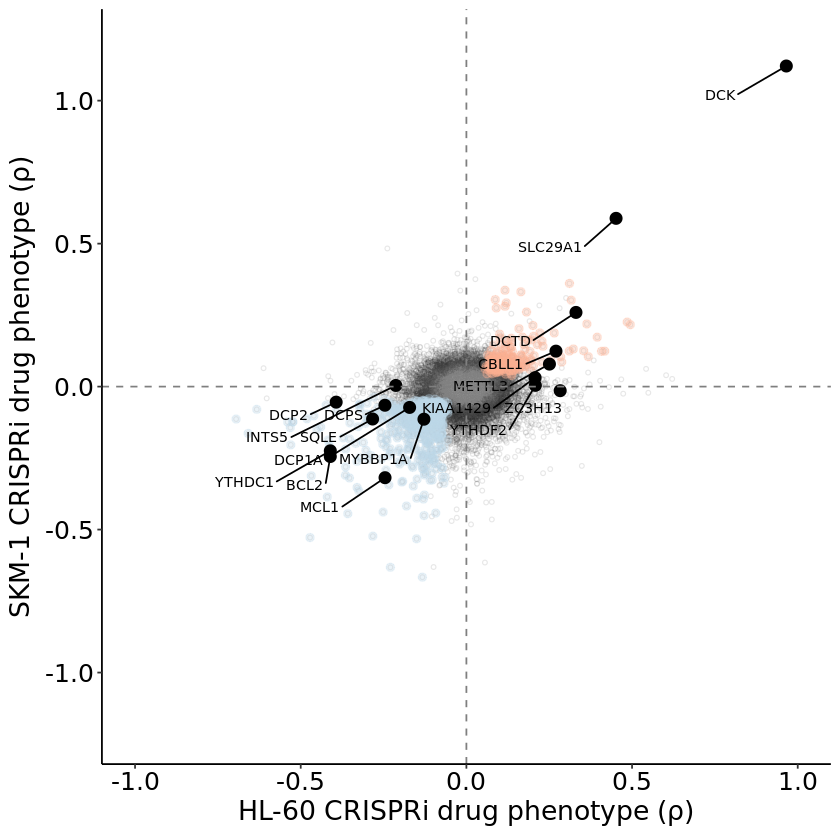

In [66]:
rho_hl60_vs_rho_skm1

___

In [90]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.1    forcats_0.5.1      stringr_1.4.0      dplyr_1.0.7       
 [5] purrr_0.3.4        readr_2.0.2        tidyr_1.1.4        tibble_3.1.6      
 [9] tidyverse_1.3.1    RColorBrewer_1.1-2 ggrepel_0.9.1      ggplot2_3.3.5     

loaded via a namespace (and not attached):
 [1